# Figure 4.17 of Chapter 4

In [1]:
from summer2 import CompartmentalModel
import matplotlib.pyplot as plt

In [2]:
# Raw input parameters
latent_period = 8.
infectious_period = 7.
r0 = 13.
life_expectancy = 70.
population = 1e5
seed = 1.

# Derived parameters
beta = r0 / infectious_period
progression = 1. / latent_period
recovery = 1. / infectious_period
mortality = 1. / life_expectancy / 365.

# Create the SEIR model with demographic processes
compartments = (
    "Susceptible", 
    "Pre-infectious", 
    "Infectious", 
    "Immune"
)
seir_demog_model = CompartmentalModel(
    times=(0, 25550.),
    compartments=compartments,
    infectious_compartments=["Infectious"],
)
seir_demog_model.set_initial_population(
    distribution={
        "Susceptible": population - seed, 
        "Infectious": seed,
    }
)
seir_demog_model.add_infection_frequency_flow(
    name="infection", 
    contact_rate=beta,
    source="Susceptible", 
    dest="Pre-infectious"
)
seir_demog_model.add_transition_flow(
    name="progression", 
    fractional_rate=progression,
    source="Pre-infectious", 
    dest="Infectious"
)
seir_demog_model.add_transition_flow(
    name="recovery", 
    fractional_rate=recovery, 
    source="Infectious", 
    dest="Immune",
)
seir_demog_model.add_universal_death_flows(
    "universal_death",
    death_rate=mortality,
)
seir_demog_model.add_replacement_birth_flow(
    "births",
    "Susceptible",
)

seir_demog_model.request_output_for_flow(
    name="incidence", 
    flow_name="progression",
)

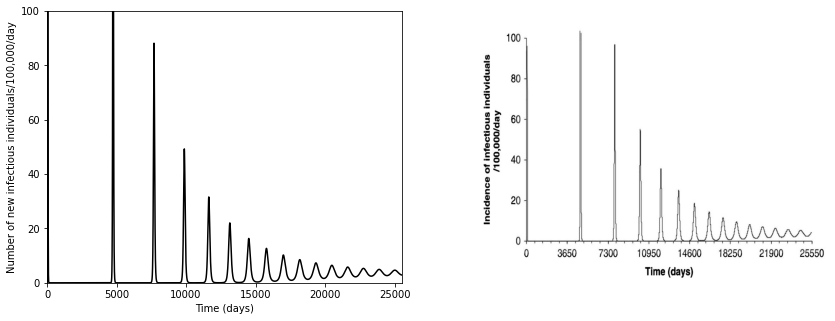

In [4]:
outputs = seir_demog_model.get_outputs_df()
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
left_ax.plot(seir_demog_model.times, seir_demog_model.derived_outputs["incidence"], color="k")
left_ax.set_xlabel("Time (days)")
left_ax.set_xlim((0., 25550.))
left_ax.set_ylabel("Number of new infectious individuals/100,000/day")
left_ax.set_ylim((0, 100.))
image = plt.imread("./figures/fig_4_17.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");

In [10]:
derived_outputs = seir_demog_model.get_derived_outputs_df()
derived_outputs.index = derived_outputs.index / 365.

In [20]:
output_props = outputs / population

In [6]:
outputs.index = outputs.index / 365.

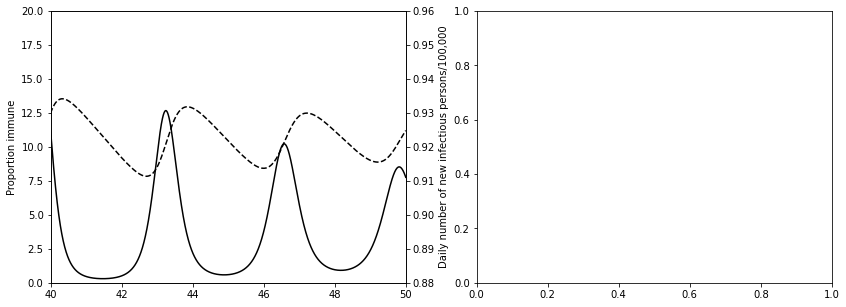

In [28]:

fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))

left_ax.plot(
    derived_outputs.index,
    derived_outputs["incidence"],
    color="k",
)
left_ax.set_xlim(40., 50.)
left_ax.set_ylim(0., 20.)
left_ax.set_ylabel("Proportion immune")

twin_ax = left_ax.twinx()
twin_ax.plot(
    output_props.index,
    output_props["Immune"],
    color="k",
    linestyle="--",
)
twin_ax.set_ylabel("Daily number of new infectious persons/100,000")
twin_ax.set_ylim(0.88, 0.96);